In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("air-traffic-passenger-statistics.csv")

In [3]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [4]:
df.isnull().sum()

Activity Period                 0
Operating Airline               0
Operating Airline IATA Code    63
Published Airline               0
Published Airline IATA Code    63
GEO Summary                     0
GEO Region                      0
Activity Type Code              0
Price Category Code             0
Terminal                        0
Boarding Area                   0
Passenger Count                 0
dtype: int64

In [5]:
df.shape

(18885, 12)

In [6]:
df["Operating Airline IATA Code"].nunique()

82

In [7]:
df.loc[df["Operating Airline IATA Code"].isnull(),"Operating Airline"].value_counts()

Servisair               36
Swissport USA           22
Pacific Aviation         2
Trego Dugan Aviation     2
Boeing Company           1
Name: Operating Airline, dtype: int64

In [8]:
df.loc[df["Operating Airline"]=="Servisair","Operating Airline IATA Code"]

6809     NaN
6810     NaN
7168     NaN
7169     NaN
7742     NaN
7743     NaN
7967     NaN
7968     NaN
8323     NaN
8324     NaN
8441     NaN
8442     NaN
8559     NaN
8560     NaN
8677     NaN
8792     NaN
8793     NaN
8794     NaN
8795     NaN
9130     NaN
9131     NaN
9356     NaN
9357     NaN
9467     NaN
9698     NaN
9699     NaN
9936     NaN
9937     NaN
10172    NaN
10173    NaN
10401    NaN
10402    NaN
10839    NaN
10840    NaN
11537    NaN
11538    NaN
Name: Operating Airline IATA Code, dtype: object

In [9]:
df.loc[df["Operating Airline"]=="Servisair","Operating Airline IATA Code"]=df.loc[df["Operating Airline"]=="Servisair","Operating Airline IATA Code"].fillna("SER")

In [10]:
df[["Operating Airline IATA Code","Operating Airline"]]

,Operating Airline IATA Code,Operating Airline
0,TZ,ATA Airlines
1,TZ,ATA Airlines
2,TZ,ATA Airlines
3,AC,Air Canada
4,AC,Air Canada
...,...,...
18880,WW,WOW Air
18881,WS,WestJet Airlines
18882,WS,WestJet Airlines
18883,SE,XL Airways France


In [11]:
df1=df[["Operating Airline IATA Code","Operating Airline"]]

In [12]:
df1.drop_duplicates(inplace=True)

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\4156330626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(inplace=True)


In [13]:
pd.set_option("max_rows",None)

OptionError: 'Pattern matched multiple keys'

In [14]:
df2=df1[df1["Operating Airline IATA Code"].isnull()]

In [15]:
df2

,Operating Airline IATA Code,Operating Airline
148,NaN,Boeing Company
6920,NaN,Pacific Aviation
9484,NaN,Swissport USA
16868,NaN,Trego Dugan Aviation


In [16]:
for i in range(df.shape[0]):
    if df["Operating Airline"][i]=="Boeing Company":
        df["Operating Airline IATA Code"][i]="BO"
    elif df["Operating Airline"][i]=="Servisair":
        df["Operating Airline IATA Code"][i]="SER"
    elif df["Operating Airline"][i]=="Pacific Aviation":
        df["Operating Airline IATA Code"][i]="PA"
    elif df["Operating Airline"][i]=="Swissport USA":
        df["Operating Airline IATA Code"][i]="SUSA"
    elif df["Operating Airline"][i]=="Trego Dugan Aviation":
        df["Operating Airline IATA Code"][i]="TDA"
    else:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\4192630888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Operating Airline IATA Code"][i]="BO"
C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\4192630888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Operating Airline IATA Code"][i]="SER"
C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\4192630888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Operating A

10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
1079

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\4192630888.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Operating Airline IATA Code"][i]="TDA"


In [17]:
for i in range(df.shape[0]):
    if df["Published Airline"][i]=="Boeing Company":
        df["Published Airline IATA Code"][i]="BO"
    elif df["Published Airline"][i]=="Servisair":
        df["Published Airline IATA Code"][i]="SER"
    elif df["Published Airline"][i]=="Pacific Aviation":
        df["Published Airline IATA Code"][i]="PA"
    elif df["Published Airline"][i]=="Swissport USA":
        df["Published Airline IATA Code"][i]="SUSA"
    elif df["Published Airline"][i]=="Trego Dugan Aviation":
        df["Published Airline IATA Code"][i]="TDA"
    else:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\1198590464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Published Airline IATA Code"][i]="BO"
C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\1198590464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Published Airline IATA Code"][i]="SER"
C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\1198590464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Published A

2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235


7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717


15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
1529

17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
17628
17629
17630
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
1775

C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\1198590464.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Published Airline IATA Code"][i]="SUSA"
C:\Users\ahmet\AppData\Local\Temp\ipykernel_11456\1198590464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Published Airline IATA Code"][i]="TDA"


In [18]:
df.isnull().sum()

Activity Period                0
Operating Airline              0
Operating Airline IATA Code    0
Published Airline              0
Published Airline IATA Code    0
GEO Summary                    0
GEO Region                     0
Activity Type Code             0
Price Category Code            0
Terminal                       0
Boarding Area                  0
Passenger Count                0
dtype: int64

In [19]:
df.head(10)

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090
5,200507,Air China,CA,Air China,CA,International,Asia,Deplaned,Other,International,G,6263
6,200507,Air China,CA,Air China,CA,International,Asia,Enplaned,Other,International,G,5500
7,200507,Air France,AF,Air France,AF,International,Europe,Deplaned,Other,International,A,12050
8,200507,Air France,AF,Air France,AF,International,Europe,Enplaned,Other,International,A,11638
9,200507,Air New Zealand,NZ,Air New Zealand,NZ,International,Australia / Oceania,Deplaned,Other,International,G,4998


In [20]:
df["Terminal"].unique()

array(['Terminal 1', 'International', 'Terminal 3', 'Other', 'Terminal 2'],
      dtype=object)

In [21]:
x=df.drop(["Operating Airline","Operating Airline IATA Code","Published Airline","Published Airline IATA Code","GEO Summary"],axis=1)

In [22]:
x.head()

,Activity Period,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Canada,Enplaned,Other,Terminal 1,B,34090


In [23]:
x=pd.get_dummies(x)

In [24]:
model=KMeans(n_clusters=3)#3 tane sınıfa ayırcağınızı söylüyorsunuz
model=model.fit(x)
pred=model.predict(x)
x["cluster"]=pred#tahminlerimizi Datamız koyuyoruz

In [27]:
x.sample(40)#verimizde de artik sınıflandırmayı görebiliyoruz

,Activity Period,Passenger Count,GEO Region_Asia,GEO Region_Australia / Oceania,GEO Region_Canada,GEO Region_Central America,GEO Region_Europe,GEO Region_Mexico,GEO Region_Middle East,GEO Region_South America,...,Terminal_Terminal 3,Boarding Area_A,Boarding Area_B,Boarding Area_C,Boarding Area_D,Boarding Area_E,Boarding Area_F,Boarding Area_G,Boarding Area_Other,cluster
12010,201402,4902,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12409,201406,18869,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11606,201311,6244,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12843,201410,6850,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9581,201205,23927,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4708,200811,12345,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1099,200604,13980,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1004,200603,46236,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9986,201208,183011,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
15959,201610,276,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
silhouette_score(x,pred)#başarı oranımız

0.8281862195501195

In [29]:
#Acaba kaç gruba ayırsam dah doğru sonuçalırım
def clust(clusters):
    for no_of_cluster in np.arrange(1,clusters):
        no_of_cluster+=1
        model=KMeans(n_clusters=no_of_cluster)
        model=model.fit(x)
        pred=model.predict(x)
        score=silhouette_score(x,pred)
        print("Number of cluster {},silhouette{}".format(no_of_cluster,score))

In [30]:
clust=x.assign(Cluster=model.labels_)
model.cluster_centers_.astype("int")#clsutering yaparkenki noktaların merkezini gösteriyor
model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
df.columns

Index(['Activity Period', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count'],
      dtype='object')

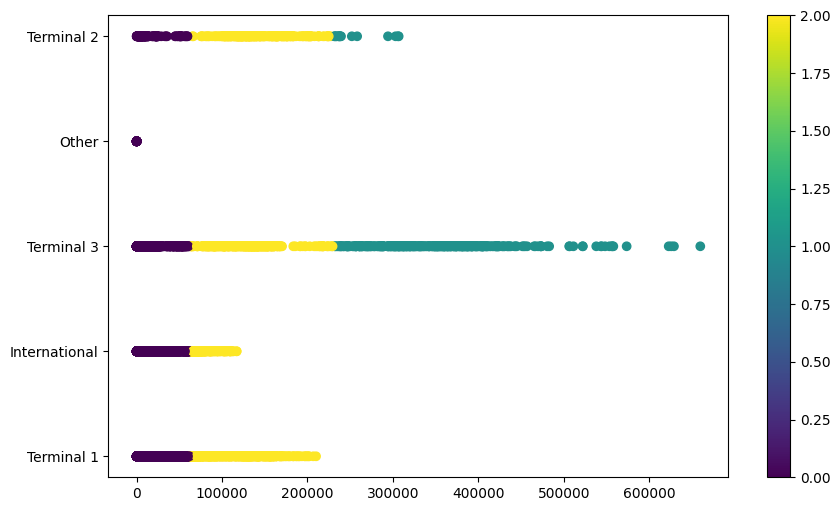

In [32]:
#burda ayırmış olduğumuz 4 farklı grup için renklendirilmiş verisini görüyoruz
plt.figure(figsize=(10,6))
plt.scatter(x["Passenger Count"],df["Terminal"],c=pred)
plt.colorbar()
plt.show()

In [33]:
pred

array([0, 0, 0, ..., 0, 0, 0])

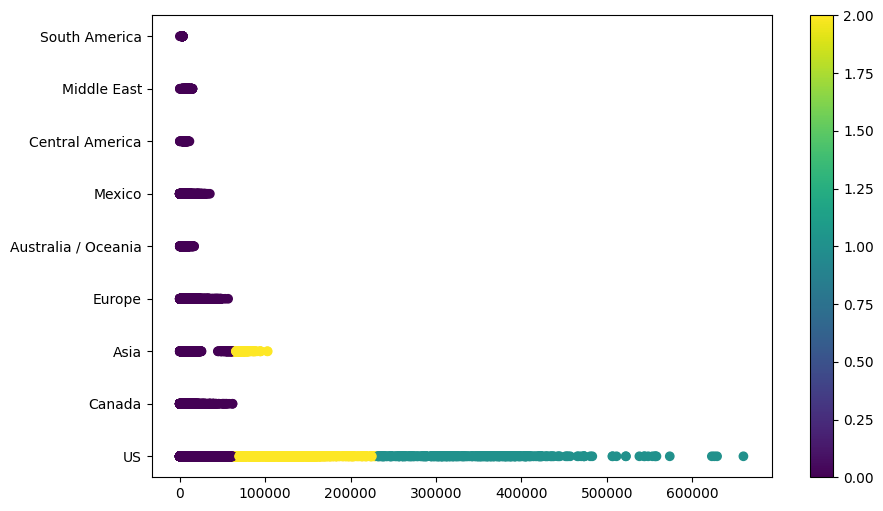

In [34]:
#burda ayırmış olduğumuz 4 farklı grup için renklendirilmiş verisini görüyoruz
plt.figure(figsize=(10,6))
plt.scatter(x["Passenger Count"],df["GEO Region"],c=pred)
plt.colorbar()
plt.show()

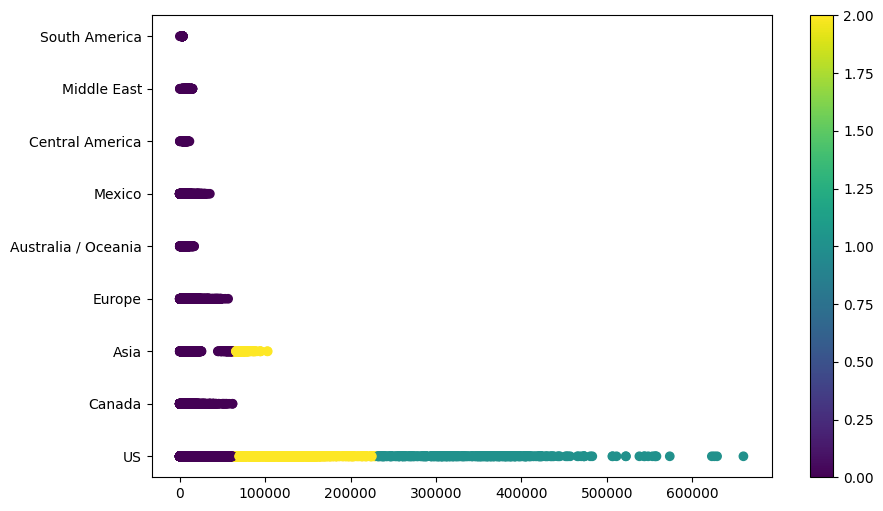

In [35]:
#burda ayırmış olduğumuz 4 farklı grup için renklendirilmiş verisini görüyoruz
plt.figure(figsize=(10,6))
plt.scatter(x["Passenger Count"],df["GEO Region"],c=pred)
plt.colorbar()
plt.show()

In [36]:
#Acaba doğru mu yaptım acaba kaç sınıfa ayırmam lazım dedim
allscore=[]
allclusters=[]
def clust(clusters):
    for no_of_cluster in np.arange(1,clusters):
        no_of_cluster+=1
        model=KMeans(n_clusters=no_of_cluster)
        #model=model.fit(x)
        pred=model.fit_predict(x)
        score=silhouette_score(x,pred)
        print("Number of cluster {},silhouette{}".format(no_of_cluster,score))
        allscore.append(score)
        allclusters.append(no_of_cluster)
clust(10)#10 sınfa kadar deniyorum acaba hangisi daha iyi

Number of cluster 2,silhouette0.859445729556919
Number of cluster 3,silhouette0.8281862195501195
Number of cluster 4,silhouette0.7852585348171728
Number of cluster 5,silhouette0.7837146713110756
Number of cluster 6,silhouette0.6588272291721874
Number of cluster 7,silhouette0.6591386545208657
Number of cluster 8,silhouette0.6429604454527447
Number of cluster 9,silhouette0.6368854232782837
Number of cluster 10,silhouette0.6093943292585161


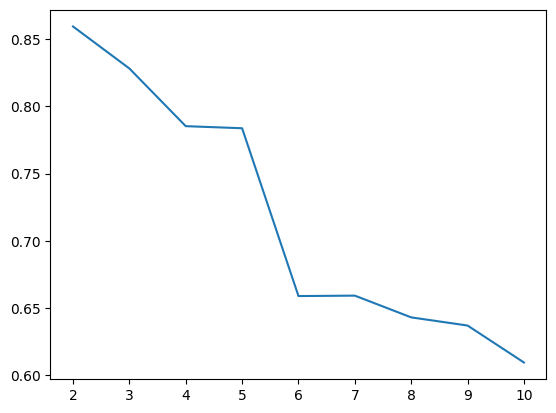

In [37]:
plt.plot(allclusters,allscore)

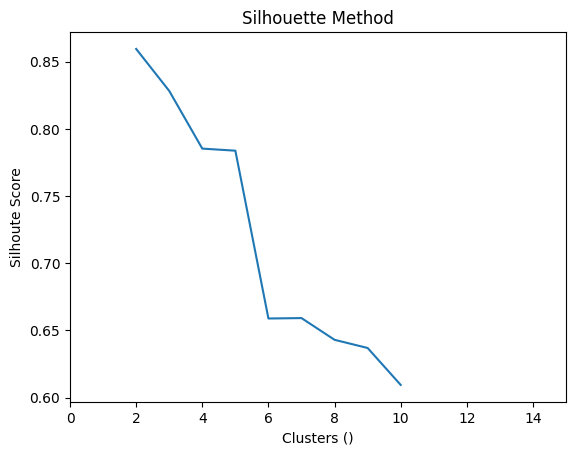

In [38]:
plt.plot(allclusters,allscore)
plt.xlabel("Clusters ()")
plt.ylabel("Silhoute Score")
plt.title("Silhouette Method")
plt.xlim(0,15)
plt.show()

In [39]:
allscore=[]
allclusters=[]
sum_of_squared_distances=[]
def clust(clusters):
    for no_of_cluster in np.arange(1,clusters):
        no_of_cluster+=1
        model=KMeans(n_clusters=no_of_cluster)
        #model=model.fit(x)
        pred=model.fit_predict(x)
        sum_of_squared_distances.append(model.inertia_)
        score=silhouette_score(x,pred)
        print("Number of cluster {},silhouette{}".format(no_of_cluster,score))
        allscore.append(score)
        allclusters.append(no_of_cluster)
clust(9)

Number of cluster 2,silhouette0.859445729556919
Number of cluster 3,silhouette0.8281862195501195
Number of cluster 4,silhouette0.7852585348171728
Number of cluster 5,silhouette0.7837146713110756
Number of cluster 6,silhouette0.6588272291721874
Number of cluster 7,silhouette0.6575988658714168
Number of cluster 8,silhouette0.6427353251690473
Number of cluster 9,silhouette0.6347915688808281


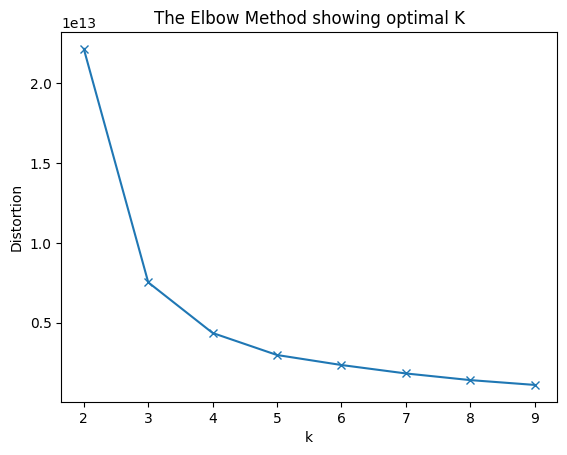

In [40]:
plt.plot(allclusters,sum_of_squared_distances,marker="x")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing optimal K")
plt.show()#dirsek metodunda nerden kırılıyorsa o sayıda sınıfa bölmek en iyisi olur diyoruz bu örnek için 4 mesela 